In [92]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
%matplotlib inline

# Mini-ViT

Finished 10-4-24

using a imagenet image, model made for that specific image size and patch. 224x224x3 patch side length 16.

No device casting, batching, or optimization tricks done, this was made to better understand the general flow of information and design of the ViT architecture.

-------------------------------------------------------

Notes:

9-26: I was originally trying to do this without looking at anybody elses implementation. But I got confused on some of the cls token stuff and when I looked implementations of the paper up they used 2d convolutions, while the paper says they used a linear projection. Did they just update the paper later or what happened?  Embeddings make sense as a lookup table with NLP but when we get to images idk what they are. But I'm guessing lookup table of image patches is too simplistic.


10-4: It is all working correct, but I will say I don't fully know if my implementation of attention is correct even though I did try to follow the o.g implementation (with pytorch's implementation for it since I didn't want to reinvent the wheel again). I guess I don't really get what the model is attending too, it makes sense with regular tokens but not when I am working with reshaped image patches. Which leads me to think the implementation is probably wrong, but the network does still learn. I need to do more research on it. And probably understand attention better in general.

---------------------------------------------------------------

Resources:

https://arxiv.org/pdf/2010.11929

https://github.com/karpathy/nanoGPT/blob/master/model.py

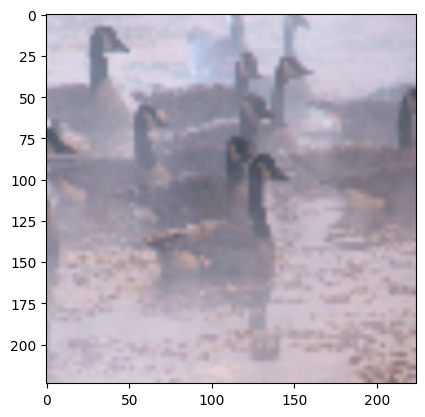

In [116]:
im = cv2.imread("OneDuckingImage.png")
im.shape
plt.imshow(im)

In [94]:
H,W = 224,224
p = 16
N = (H*W) / (p**2) #number of patches
N

196.0

In [95]:
((N*10) % 10) == 0

True

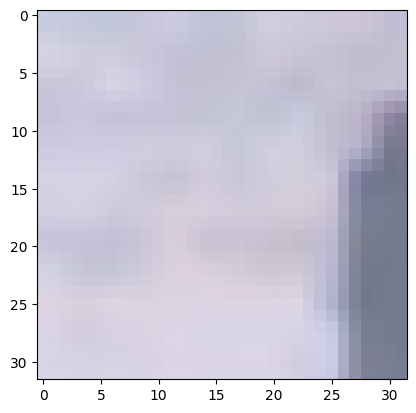

In [117]:
patch1 = im[:32,:32,:]
plt.imshow(patch1)

In [97]:
D = 1024

In [98]:
#If I'm reading the paper right, they take the patches, flatten them, then embed them, page 4.

def patchify(image, patch_side_length=16):
  simple_arr = []
  H,W,C = image.shape
  patch_amount = (H*W) / (patch_side_length**2)
  assert(((patch_amount * 10) % 10) == 0) #patches correctly deivde up image into even parts
  #print(f"Generating {int(patch_amount)} patches, each of size {patch_side_length} x {patch_side_length} with {C} channels")

  row_patch_end = patch_side_length
  row_patch_start = 0
  col_patch_end = patch_side_length
  col_patch_start = 0

  h_slider = 1
  v_slider = 1

  for i in range(int(patch_amount)):
    patch = image[row_patch_start:row_patch_end,col_patch_start:col_patch_end,:]

    if i == 0:
      simple_arr = patch.flatten()
      #print(i,"Row:", row_patch_start,row_patch_end,"Col:",col_patch_start,col_patch_end, 'W:' ,W) debugging info
    else:
      newstack = patch.flatten()
      #print(newstack.shape,i,"Row:", row_patch_start,row_patch_end,"Col:",col_patch_start,col_patch_end, 'W:' ,W)
      simple_arr = np.vstack((simple_arr,newstack))

    if col_patch_end == W:
      col_patch_end = patch_side_length
      col_patch_start = 0
      h_slider = 1
      row_patch_start = row_patch_end
      row_patch_end = patch_side_length * (v_slider + 1)
      v_slider += 1
    else:
      col_patch_start = col_patch_end
      col_patch_end = patch_side_length * (h_slider + 1)
      h_slider += 1

  return simple_arr


patch_arr = patchify(im)

patch_arr.shape

(196, 768)

In [99]:
patch_arr[1].shape

(768,)

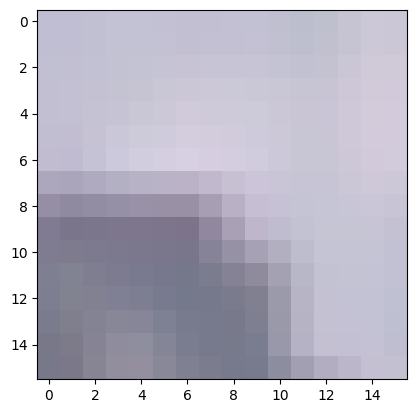

In [100]:
out2 = patch_arr[2].reshape(16,16,3)
plt.imshow(out2) # I assume this is the top of its head? top left

each patch will be flattened to 16x16x3 = 1 x 768  

which will go through an embedding to become a 1 x 1024

(1 x 768) x (768 x 1024)

final x after patching and embedding all layers will be a

R^(192 + 1 x 1024), 1024 embedding dimension size, 192 is amount of patches + 1 for class token append.


TODO:

Make a patch and project function for the model which takes an image, takes a patch from it, flattens it, projects it to a higher dimention with embedding matrix E (see page 3,4), and then concatinates it vertically onto a x tensor to get the inputs into the encoder.


In [101]:
patch_size = 768
embed_size = 1024
amount_patches = 196
MLP_size = 4096 #nice number 2^12
heads = 16

In [102]:
#Layers and model spec
#https://pytorch.org/docs/stable/generated/torch.vstack.html

#class MHA(nn.Module):


#class MLP(nn.Module):

#class EncoderBlock(nn.Module):

#class ViTModel(nn.Module):


In [103]:
#ViT class setup
class ViTModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.img_patch_projection = nn.Linear(patch_size,embed_size)    # linear projection into higher D, (1 x 768) x (768 x 1024) -> (1,1024)
    self.position_embedding = nn.Parameter(torch.randn(amount_patches + 1, 1024)) # N x D, need to add class token
    self.cls_token = nn.Parameter(torch.zeros(1, embed_size)) #for classification token at beginning of embedding, 1xD
    self.cls_token = nn.init.trunc_normal_(self.cls_token, std = .02)

  def forward(self,img,target = None):
    #For simplicity batch is 1 image, target is 1 image label
    emb_patches = self.patch_and_embed_img(img)

    #add special token to front
    #cls_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.vstack((self.cls_token, emb_patches))
    return x



  def patch_and_embed_img(self,img):
    """ returns np array of the patches now embedded, """
    patched_img = patchify(img) # 196 x 768
    embedded_patches = []
    first = True

    for i in patched_img: #is there a way to vectorize this?
      patch = i.reshape(1,768)
      patch = torch.Tensor(patch)
      embedded_patch = self.img_patch_projection(patch) # output should be 1 x 1024
      if first:
        embedded_patches = embedded_patch
        first = False
      else:
        embedded_patches = torch.vstack((embedded_patches,embedded_patch))


    return embedded_patches # should be 196 + x 1024





In [104]:
model = ViTModel()
embed_im = model.patch_and_embed_img(im)
pos = model.position_embedding
pos.shape

torch.Size([197, 1024])

In [105]:
x = model(im)
x.shape

torch.Size([197, 1024])

In [106]:
# MHA setup
class EncoderMHA(nn.Module):
  def __init__(self):
    super().__init__()
    assert embed_size % heads == 0
    self.head_dim = embed_size // heads
    self.attn = nn.Linear(embed_size, 3 * embed_size, bias = False)
    self.proj = nn.Linear(embed_size,embed_size)
    self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

  def forward(self,x):
    # x should be [197,1024]
    B,E = x.size()
    q, k, v  = self.attn(x).split(embed_size,dim=-1) #projects 1024 to 3072 then splits them into q,k,v all sized 197,1024
    q = q.view(B,heads,E // heads) #16 heads and 64 tokens per head
    k = k.view(B,heads,E // heads)
    v = v.view(B,heads,E // heads)

    if self.flash:
        # efficient attention using Flash Attention CUDA kernels
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p= 0, is_causal=False) #the is causal = false means all tokens attend to each other even "future" tokens
    y = y.view(B,E)

    # I forgot why we do this projection, should read more about attention and how it works.
    y = self.proj(y)

    return y




In [107]:
enc = EncoderMHA()
x = enc(x)
x.shape

torch.Size([197, 1024])

In [108]:
#MLP class setup
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(embed_size,MLP_size, bias=False)
    self.proj = nn.Linear(MLP_size,embed_size,bias=False)
    self.gelu = nn.GELU()

  def forward(self, x):
    x = self.fc(x)
    x = self.gelu(x)
    x = self.proj(x)
    return x

In [109]:
test_mlp = MLP()
x = test_mlp(x)
x.shape

torch.Size([197, 1024])

In [110]:
# Actual encoder block
class EncoderBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.ln_1 = nn.LayerNorm(embed_size,bias=False)
    self.EncMHA = EncoderMHA()
    self.ln_2 = nn.LayerNorm(embed_size,bias=False)
    self.block_MLP = MLP()

  def forward(self,x):
    x = x + self.EncMHA(self.ln_1(x))
    x = x + self.block_MLP(self.ln_2(x))
    return x



In [111]:
test_enc_block = EncoderBlock()
x = test_enc_block(x)
x.shape

torch.Size([197, 1024])

In [112]:
#All together
class ViTModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.img_patch_projection = nn.Linear(patch_size,embed_size)    # linear projection into higher D, (1 x 768) x (768 x 1024) -> (1,1024)
    self.position_embedding = nn.Parameter(torch.randn(amount_patches + 1, 1024)) # N x D, need to add class token
    self.cls_token = nn.Parameter(torch.zeros(1, embed_size)) #for classification token at beginning of embedding, 1xD
    self.cls_token = nn.init.trunc_normal_(self.cls_token, std = .02)
    self.fn_ln = nn.LayerNorm(embed_size,bias=False)
    self.block = EncoderBlock()
    self.fn_head = nn.Linear(embed_size, 5, bias=False) #embeded size to class amount for classification

  def forward(self,img,target = None):
    #For simplicity batch is 1 image, target is 1 image label
    emb_patches = self.patch_and_embed_img(img)

    #add special token to front
    x = torch.vstack((self.cls_token, emb_patches))
    x = x + self.position_embedding
    x = self.block(x) #output of 1 encoder block layer
    x = self.fn_ln(x) #one last layer norm
    x = x[0] # get cls token
    logits = self.fn_head(x)

    return logits



  def patch_and_embed_img(self,img):
    """ returns np array of the patches now embedded, """
    patched_img = patchify(img) # 196 x 768
    embedded_patches = []
    first = True

    for i in patched_img: #is there a way to vectorize this?
      patch = i.reshape(1,768)
      patch = torch.Tensor(patch)
      embedded_patch = self.img_patch_projection(patch) # output should be 1 x 1024
      if first:
        embedded_patches = embedded_patch
        first = False
      else:
        embedded_patches = torch.vstack((embedded_patches,embedded_patch))


    return embedded_patches # should be 196 + x 1024

In [113]:
model = ViTModel()
logits = model(im)
logits
F.softmax(logits) # looks mostly okay, all "classes" should be uniform initally since model doesn't know anything

<ipython-input-113-457c126f975e>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logits) # looks mostly okay, all "classes" should be uniform initally since model doesn't know anything


tensor([0.1942, 0.3135, 0.1867, 0.1534, 0.1522], grad_fn=<SoftmaxBackward0>)

In [114]:
#Train loop

#pretend targets, think ball, plane, birds, boat, shoe
targets = torch.Tensor([0,0,1,0,0])

model = ViTModel()
optimizer = torch.optim.Adam(model.parameters(),lr=.001,betas=(.9,.999))

for i in range(5):
  batch = im
  logits = model(batch)
  loss = F.cross_entropy(logits,target=targets)
  print(loss)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

tensor(1.5706, grad_fn=<DivBackward1>)
tensor(2.2650e-06, grad_fn=<DivBackward1>)
tensor(1.0729e-06, grad_fn=<DivBackward1>)
tensor(2.1458e-06, grad_fn=<DivBackward1>)
tensor(1.2040e-05, grad_fn=<DivBackward1>)


In [115]:
new_param = nn.Parameter(torch.randn(196 + 1, 1024))
new_param.shape

torch.Size([197, 1024])